<a href="https://colab.research.google.com/github/raulbenitez/AMRITA_UPC/blob/main/generate_blobs_properties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Generate synthetic blobs database

In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.util import random_noise

L = 256 
N = 2000 # number of images

I = np.zeros((L,L,N))
IG = np.zeros((L,L,N))
IL = np.zeros((L,L,N))

v = np.zeros(N)
for k in range(N):
  I_aux = data.binary_blobs(length=L, blob_size_fraction=0.1,volume_fraction=0.3)
  I[:,:,k] = I_aux
  IG[:,:,k] = I_aux*random_noise(I[:,:,1], mode='gaussian', mean=0.1,var=0.01)

  label_image, nregions = measure.label(I[:,:,k],return_num=True)
  IL[:,:,k] = label_image
  props_aux = measure.regionprops_table(label_image,properties=['label','area','eccentricity','extent'])

  if k == 0:
    df = pd.DataFrame(props_aux)
  else: 
    df = df.append(pd.DataFrame(props_aux), ignore_index=True)

  df_aux = pd.DataFrame(props_aux)
  a_max = max(df_aux['area'].values)

# label images with a blob with area larger than 4000 as abnormal type (class label = 1)
  if a_max > 4000:
    v[k] = 1

  #print('Image number {}, number of regions {}, area of largest region {}, class {}'.format(k,nregions,a_max,v[k]))

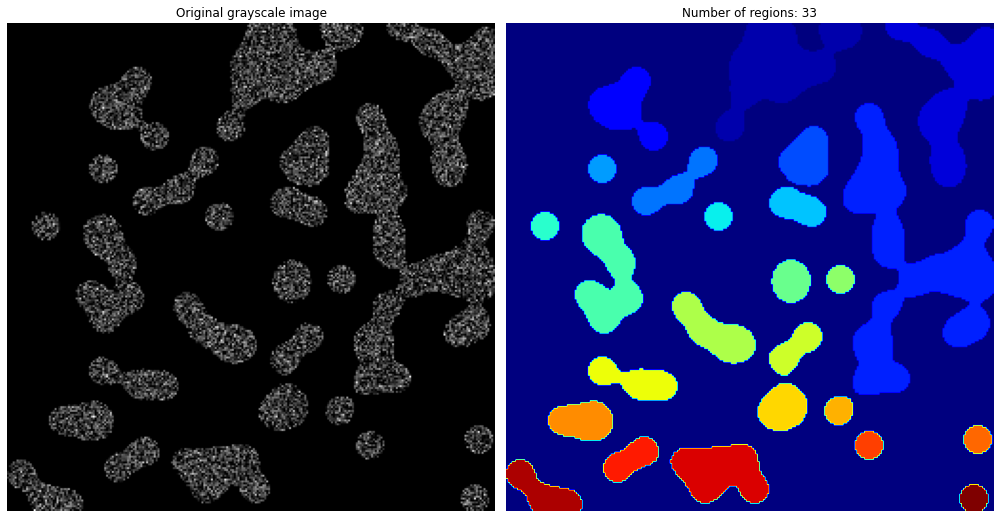

In [2]:
# Get some figures:
fig, axes = plt.subplots(1,2,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(IG[:,:,0],cmap=plt.cm.gray)
ax[0].set_title('Original grayscale image') 
ax[1].imshow(IL[:,:,0],cmap=plt.cm.jet)
ax[1].set_title('Number of regions: {}'.format(nregions)) # set figure title

ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

In [24]:
np.min(I[:,:,0])

0.0

Visualize the features:

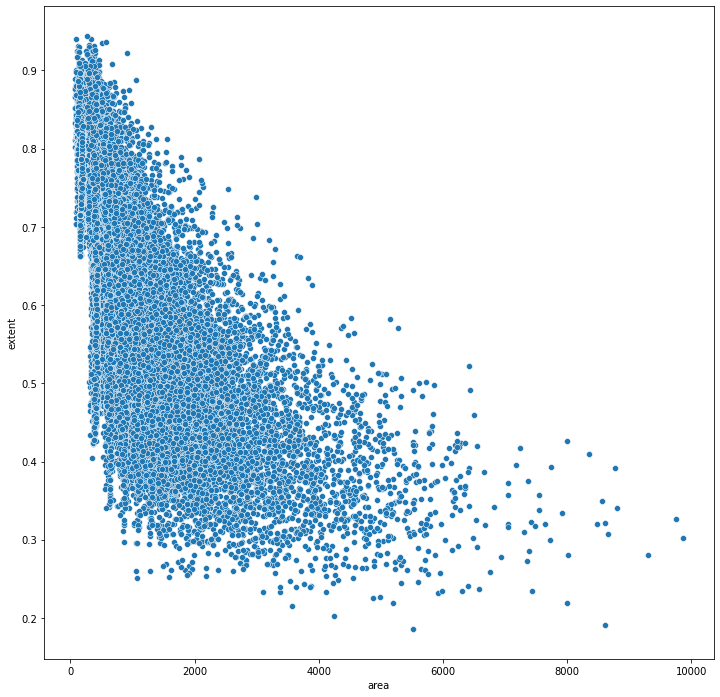

In [8]:
import seaborn as sns

fig = plt.figure(figsize=(12,12))

sns.scatterplot(x='area',y='extent',data=df)

#2. Train a DL model

To classify images according to the class (class=0 if there are no large blobs and class = 1 if the image contains a large blob)


Shape data and split in training and test subsets:

In [9]:
X = np.expand_dims(IG, -1)
X = np.transpose(X, (2,1,0,3))
X.shape
y=v

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

When data is uint8, scale and convert to float

In [14]:
#X_train = X_train / 255.
#X_test = X_test / 255.
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')

In [15]:
X_train.shape

(1340, 256, 256, 1)

In [16]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Model / data parameters
num_classes = 2
input_shape = (L, L, 1)

# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

# Train model:
batch_size =64
epochs = 5

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 246016)            0         
                                                                 
 dropout (Dropout)           (None, 246016)            0

In [17]:
# Validate model
from sklearn.metrics import classification_report

label_names = ['normal', 'pathological']

score = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(X_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 0.5934102535247803
Test accuracy: 0.7212121486663818
              precision    recall  f1-score   support

      normal       0.72      1.00      0.84       476
pathological       0.00      0.00      0.00       184

    accuracy                           0.72       660
   macro avg       0.36      0.50      0.42       660
weighted avg       0.52      0.72      0.60       660



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
y_test_pred = np.argmax(model.predict(X_test),axis=1)

In [20]:
print(y_test_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

#3. Apply a DL interpretability method (GradCAM++): 

In order to see of the large regions are more relevant to classify the anomalous images